# MLOps for Adult Lung Segmentation 

## Imports

In [28]:
import torch
from torch.utils.data import random_split
from torch import optim
import pytorch_lightning as pl
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import monai
from monai.losses import DiceCELoss
from monai.networks.nets import UNETR
from monai.data import DataLoader, Dataset
from monai.transforms import ( Compose, Resized, 
                              ToTensord, NormalizeIntensityd, 
                              LoadImaged, EnsureChannelFirstd, 
                              RandAffined )
import numpy as np
import glob
import SimpleITK as sitk

# Through pytorch lightning
from lightning.pytorch.loggers import MLFlowLogger

# Or directly:
import mlflow

print(torch.cuda.is_available())

True


## Set up MLflow tracking server

In [29]:
### Start a server with
# mlflow ui

# Connect MLflow session to server
mlflow.set_tracking_uri("http://localhost:5000")

# To test out using an SFTP server - shared cluster?
# Test out mlflow logging
mlflow.set_experiment("/check-localhost-connection")

with mlflow.start_run():
    mlflow.log_metric("foo",1)
    mlflow.log_metric("bar",2)


In [ ]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the grocery forecasting project. "
    "This experiment contains the produce models for apples."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "grocery-forecasting",
    "store_dept": "produce",
    "team": "stores-ml",
    "project_quarter": "Q3-2023",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
produce_apples_experiment = client.create_experiment(
    name="Apple_Models", tags=experiment_tags
)

## Data Loader - using a Custom Dataset and Pytorch Lightning

In [30]:
ROOT_DIR = "C:/Users/sadhana.ravikumar/Documents/LungAirProject/LungAir_MLOps"

DATA_DIR = os.path.join(ROOT_DIR,"data","MontgomerySet") # CXR_png, ManualMask/leftMask, rightMask

image_path = os.path.join(DATA_DIR,'CXR_png')
leftmask_path = os.path.join(DATA_DIR,'ManualMask','leftMask')
rightmask_path = os.path.join(DATA_DIR,'ManualMask','rightMask')

list = os.listdir(image_path)
idx = 3

left_name = os.path.join(leftmask_path,list[idx])
right_name = os.path.join(rightmask_path,list[idx])

left = sitk.GetArrayFromImage(sitk.ReadImage(left_name))/255
right = sitk.GetArrayFromImage(sitk.ReadImage(right_name))/255

seg = left+right

print(np.unique(seg))
print(left.shape)
print(np.unique(right))

[0. 1.]
(4892, 4020)
[0. 1.]


## Custom datasets

In [31]:
class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample

    """
    def __init__(self, dataset, transform=None):

        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.dataset)
    
class LungSegmentationDataset(Dataset):
    def __init__(self, image_path,
                 leftmask_path,
                 rightmask_path, transforms):
        
        self.image_path = image_path
        self.leftmask_path = leftmask_path
        self.rightmask_path = rightmask_path
        self.list = []
        for file in os.listdir(self.image_path):
            if file.endswith('.png'):
                self.list.append(file)
        # self.list =  os.listdir(self.image_path)
        self.transform = transforms

    def __len__(self):
        return len(self.list)
    
    def __getitem__(self, idx):

        # Load Image and corresponding segmentation masks
        img_name = os.path.join(self.image_path,self.list[idx])
        left_name = os.path.join(self.leftmask_path,self.list[idx])
        right_name = os.path.join(self.rightmask_path,self.list[idx])

        img = sitk.GetArrayFromImage(sitk.ReadImage(img_name))
        left = sitk.GetArrayFromImage(sitk.ReadImage(left_name))/255
        right = sitk.GetArrayFromImage(sitk.ReadImage(right_name))/255

        seg = left + right #  Combine the right and left masks

        sample = {'image':img,'label':seg,'filename': self.list[idx]}

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

## Lung Segmentation Data Module

In [32]:
class LungSegmentationDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_path = os.path.join(self.data_dir,'CXR_png')
        self.leftmask_path = os.path.join(self.data_dir,'ManualMask','leftMask')
        self.rightmask_path = os.path.join(self.data_dir,'ManualMask','rightMask')
        self.num_workers = num_workers

        self.dims = 2

        self.transforms = Compose([EnsureChannelFirstd(keys=["image","label"], channel_dim='no_channel'), 
            Resized(keys=['image','label'], spatial_size = (512,512), mode=("bilinear","nearest")),
            NormalizeIntensityd(keys=['image']),
            ToTensord(keys=["image","label"])])
        
        self.aug_transforms = RandAffined(keys=['image','label'],mode=('bilinear','nearest'),prob=0.1,rotate_range=(0, 0, np.pi))

    def prepare_data(self):
        """
        Empty prepare_data method left in intentionally. 
        https://pytorch-lightning.readthedocs.io/en/latest/data/datamodule.html#prepare-data
        This function is used if downloading data . Processes that occcur on a single processing unit
        """
        pass

    def setup(self, stage):

        # Assign train/val datasets for use in datlaloaders
        entire_dataset =  LungSegmentationDataset(
            self.image_path,
            self.leftmask_path,
            self.rightmask_path,
            transforms = self.transforms)
        
        # Split data
        generator = torch.Generator().manual_seed(42) # reproducible split
        self.train_ds, self.val_ds, self.test_ds = random_split(entire_dataset,[0.7,0.2,0.1], generator=generator)

        # Apply data augmentation transfprms to train_ds
        self.train_ds = ApplyTransform(self.train_ds, self.aug_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_ds,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle=True)
        
    def val_dataloader(self):
        return DataLoader(self.val_ds,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_ds,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle=False)

### Test out dataset and plot image

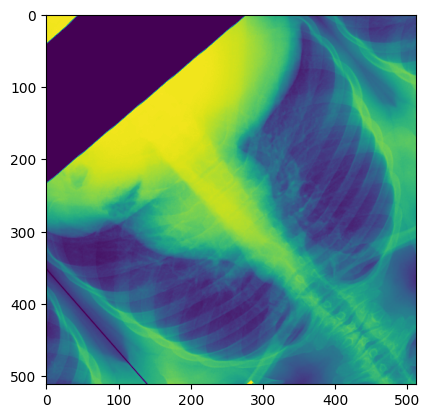

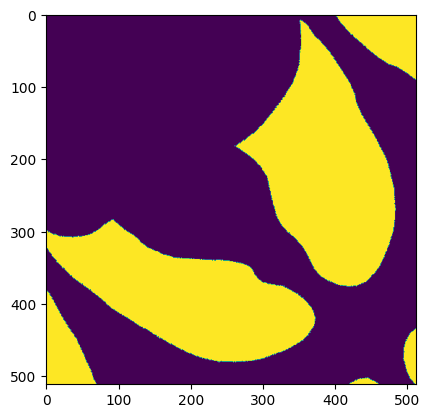

In [33]:
transforms = Compose([EnsureChannelFirstd(keys=['image','label'], channel_dim='no_channel'),
            Resized(keys=['image','label'], spatial_size = (512,512), mode=("bilinear","nearest")),
            NormalizeIntensityd(keys=['image','label']),
            ToTensord(keys=['image','label'])])
        
# Resized(keys=['image','label'], spatial_size = (512,512), mode = ('bilinear', 'nearest')), 
aug_transforms = RandAffined(keys=['image','label'],mode=('bilinear','nearest'),prob=1,rotate_range=(np.pi, 0, np.pi))

ds = LungSegmentationDataset(image_path,leftmask_path,rightmask_path,transforms=transforms)
aug_ds = ApplyTransform(ds, aug_transforms)

sample = aug_ds[4]

import matplotlib.pyplot as plt
img = sample["image"]
seg = sample["label"]
plt.imshow(img[0])
plt.figure()
plt.imshow(seg[0])

generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(ds,[0.7,0.2,0.1], generator=generator)

train_dataloader = DataLoader(train_ds,
            batch_size = 2,
            num_workers = 0,
            shuffle=True)
        
val_dataloader =DataLoader(val_ds,
            batch_size = 2,
            num_workers = 0,
            shuffle=False)

test_dataloader =DataLoader(test_ds,
            batch_size = 2,
            num_workers = 0,
            shuffle=False)

# Define Network

In [51]:
class Net(pl.LightningModule):
    def __init__(self, input_size, num_classes, learning_rate):
        super().__init__()

        self.model = UNETR(in_channels = 1, out_channels = num_classes, img_size = input_size, spatial_dims=2)
        self.loss = DiceCELoss(to_onehot_y=True, softmax=True)
        self.learning_rate = learning_rate
        self

    def forward(self,x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        print(self.learning_rate)
        #self.logger.experiment.log_hyperparams("learning_rate", self.learning_rate) 
        return optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch,batch_idx)
        # mlflow.log_metric(self.logger.run_id,"train_loss", loss)
        # self.logger.experiment.log_metrics("train_loss", loss)
        return loss
        # can return loss, log values

    def validation_step(self, batch, batch_idx):
        # validation loigic
        loss, pred, y = self.common_step(batch,batch_idx)
        # mlflow.log_metric("val_loss", loss)
        # print(self.logger._run_id)
        # self.logger.experiment.log_metric(self.logger.run_id,"val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch,batch_idx)
        return loss

    def common_step(self, batch, batch_idx):
        # training logic
        x = batch["image"]
        y = batch["label"]

        pred = self.forward(x)
        loss = self.loss(pred,y)

        return loss, pred, y
    
    def predict_step(self, batch, batch_idx):
        x = batch["image"]

        pred = self.forward(x)
        preds = torch.argmax(pred, dim=1)
        return preds


In [ ]:
class MyAccuracy(Metric):
    def __init__(self):
        super().__init__()
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("correct", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds, target):
        preds = torch.argmax(preds, dim=1)
        assert preds.shape == target.shape
        self.correct += torch.sum(preds == target)
        self.total += target.numel()

    def compute(self):
        return self.correct.float() / self.total.float()

In [45]:
# Hyperparameters

input_size = (512,512)
num_classes = 2
learning_rate = 0.001
batch_size = 2
num_epochs = 2
num_workers = 0
learning_rate = 0.01

# Start training - Main code 

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [ ]:
# Using a ombination of direct mlflow logging and pytorch lightning logger
mlflow.end_run()
mlflow_uri="http://localhost:5000"
experiment_name="Training"
run_name="baseline-montogomery"

mlflow.set_tracking_uri(mlflow_uri)
mlflow.set_experiment(experiment_name)
mlflow.pytorch.autolog()
mlflow.start_run(run_name=run_name)

# mlflow.log_params(pl.utilities.logger._flatten_dict(config))

# mlf_logger.experiment.log_artifact(
#     run_id=mlf_logger.run_id,
#     local_path=checkpoint_callback.best_model_path)


# With pytorch lightining

#Create a logger
mlf_logger = MLFlowLogger(experiment_name=mlflow.get_experiment(mlflow.active_run().info.experiment_id).name,
    tracking_uri=mlflow.get_tracking_uri(),
    run_id=mlflow.active_run().info.run_id)


    # params = {'num_classes':2} # dictionary

    # #mlflow.set_tag()
    # mlflow.log_params(params)
    # data module
dm = LungSegmentationDataModule(DATA_DIR,batch_size=batch_size, num_workers=num_workers)
print(torch.cuda.is_available())

# Network
model = Net(input_size=input_size, num_classes=num_classes, learning_rate=learning_rate)

# Trainer
trainer = pl.Trainer(min_epochs=0, max_epochs=num_epochs, accelerator = "gpu", logger = mlf_logger)


trainer.fit(model,dm)
trainer.validate(model,dm)
trainer.test(model,dm)

mlflow.end_run()